In [ ]:
import pandas as pd
import numpy as np
import logging
from typing import List, Dict, Any, Optional
from sklearn.linear_model import LinearRegression, Ridge, Lasso, BayesianRidge, LogisticRegression
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az


class ModelRunner:
    def __init__(self, csv_path: str, target: str, mode: str = 'regression', test_size: float = 0.2,
                 random_state: Optional[int] = 42, log_file: str = 'modelrunner.log', scale: bool = True,
                 model_params: Optional[Dict[str, Dict[str, Any]]] = None):
        self.df = pd.read_csv(csv_path)
        self.target = target
        self.mode = mode
        self.test_size = test_size
        self.random_state = random_state
        self.logger = self._init_logger(log_file)
        self.logger.info(f'Loaded data from {csv_path}, mode={mode}')
        self.X = self.df.drop(columns=[target])
        self.y = self.df[target]
        self.molecule_names = self.X.iloc[:, 0].tolist()
        self.X = self.X.drop(columns=[self.X.columns[0]])
        self.features = list(self.X.columns)
       
        self.scale = scale
        self.model_params = model_params or {}  # FIX: Set before _init_models()
        if self.scale:
            self.scaler = StandardScaler()
            self.X = pd.DataFrame(self.scaler.fit_transform(self.X), columns=self.X.columns)
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=self.test_size, random_state=self.random_state)
        self.models = self._init_models()
        self.results = {}

    def run_spike_and_slab_selection(self, slab_sd: float = 5.0, n_samples: int = 2000, n_tune: int = 1000,
                                     target_accept: float = 0.95, p_include: float = 0.5, verbose: bool = True):
        """
        Run spike-and-slab Bayesian variable selection using PyMC.
        Stores inclusion probabilities and posterior in self.spike_and_slab_result.
        """
        X = self.X_train.values if hasattr(self.X_train, 'values') else self.X_train
        y = self.y_train.values if hasattr(self.y_train, 'values') else self.y_train
        p = X.shape[1]
        features = self.features

        with pm.Model() as model:
            # Slab: wide Gaussian for nonzero
            spike = pm.Bernoulli('spike', p=p_include, shape=p)
            betas_slab = pm.Normal('betas_slab', mu=0, sigma=slab_sd, shape=p)
            betas = pm.Deterministic('betas', betas_slab * spike)
            intercept = pm.Normal('intercept', mu=0, sigma=10)
            sigma = pm.HalfNormal('sigma', sigma=1)

            mu = intercept + pm.math.dot(X, betas)
            y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
            trace = pm.sample(n_samples, tune=n_tune, target_accept=target_accept, chains=2, random_seed=self.random_state, progressbar=verbose)

        inclusion_probs = trace.posterior['spike'].mean(dim=("chain", "draw")).values

        self.spike_and_slab_result = {
            'trace': trace,
            'inclusion_probs': inclusion_probs,
            'features': features,
        }

        if verbose:
            print("Spike-and-Slab Feature Inclusion Probabilities:")
            for fname, prob in zip(features, inclusion_probs):
                print(f"{fname:20s}  P(included) = {prob:.3f}")

    def get_selected_features_spike_and_slab(self, threshold: float = 0.5):
        """
        Return features whose spike-and-slab inclusion probability exceeds the threshold.
        """
        if not hasattr(self, 'spike_and_slab_result'):
            raise ValueError("Run run_spike_and_slab_selection() first.")
        inclusion_probs = self.spike_and_slab_result['inclusion_probs']
        features = self.spike_and_slab_result['features']
        selected = [f for f, prob in zip(features, inclusion_probs) if prob >= threshold]
        return selected


    def _init_logger(self, log_file: str):
        logger = logging.getLogger('ModelRunner')
        logger.setLevel(logging.INFO)
        handler = logging.FileHandler(log_file)
        formatter = logging.Formatter('%(asctime)s %(levelname)s:%(message)s')
        handler.setFormatter(formatter)
        if not logger.hasHandlers():
            logger.addHandler(handler)
        return logger

    def _init_models(self) -> Dict[str, Any]:
        if self.mode == 'regression':
            model_dict = {
                'Linear': LinearRegression,
                'LR': Ridge,
                'Bayes. Ridge': BayesianRidge,
                'LASSO': Lasso,
                'SVR': SVR,
                'Tree': DecisionTreeRegressor,
                'RF': RandomForestRegressor,
                'Grad. Boost.': GradientBoostingRegressor,
                'GPR': GaussianProcessRegressor,
                'KNN': KNeighborsRegressor,
                'MLP': MLPRegressor
            }
        elif self.mode == 'classification':
            model_dict = {
                'LR': LogisticRegression,
                'SVC': SVC,
                'Tree': DecisionTreeClassifier,
                'RF': RandomForestClassifier,
                'Grad. Boost.': GradientBoostingClassifier,
                'KNN': KNeighborsClassifier,
                'MLP': MLPClassifier
            }
        else:
            raise ValueError("mode should be 'regression' or 'classification'")
        # Instantiate with provided or default parameters
        models = {}
        for name, model_cls in model_dict.items():
            params = self.model_params.get(name, {})
            if name == 'MLP':
                params.setdefault('max_iter', 1000)
            models[name] = model_cls(**params)
        return models

    def print_models(self):
        print("Available models and parameters:")
        for name, model in self.models.items():
            print(f"{name}: {model}")
            
    def analyze_gradient_boosting(self, model_key='GradientBoosting', plot=True):
        """
        Analyze Gradient Boosting model performance and feature importances.

        Parameters
        ----------
        model_key : str
            Key in self.models for the Gradient Boosting model (default: 'GradientBoosting').
        plot : bool
            Whether to show a feature importance plot (default: True).

        Returns
        -------
        dict with MAE, RMSE, R2, and feature importances
        """
        model = self.models.get(model_key)
        if model is None:
            print(f"Model '{model_key}' not found in self.models.")
            return None

        # Predict on test set
        y_pred = model.predict(self.X_test)
        mae = mean_absolute_error(self.y_test, y_pred)
        rmse = mean_squared_error(self.y_test, y_pred, squared=False)
        r2 = r2_score(self.y_test, y_pred)
        print(f"\nGradient Boosting Model Analysis ({model_key}):")
        print(f"Test MAE : {mae:.3f}")
        print(f"Test RMSE: {rmse:.3f}")
        print(f"Test R2  : {r2:.3f}")

        # Feature importances
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            print("\nTop features by importance:")
            for idx in indices[:10]:
                print(f"{self.features[idx]:25s} Importance: {importances[idx]:.4f}")

            if plot:
                plt.figure(figsize=(10, min(6, len(self.features) // 2)))
                plt.bar(range(len(importances)), importances[indices])
                plt.xticks(range(len(importances)), np.array(self.features)[indices], rotation=45, ha='right')
                plt.title("Gradient Boosting Feature Importances")
                plt.ylabel("Importance")
                plt.tight_layout()
                plt.show()
        else:
            print("Model does not have 'feature_importances_' attribute.")

        return {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'importances': importances if 'importances' in locals() else None,
            'sorted_indices': indices if 'indices' in locals() else None
        }

    def run_all(self, scoring: Optional[str] = None, cv: int = 5, gridsearch: bool = False, param_grids: Optional[Dict[str, dict]] = None):
        if self.mode == 'regression':
            default_scoring = 'neg_mean_squared_error'
        else:
            default_scoring = 'accuracy'
        scoring = scoring or default_scoring
        self.logger.info(f'Running all models with scoring={scoring} and cv={cv}')
        for name, model in self.models.items():
            try:
                if gridsearch and param_grids and name in param_grids:
                    search = GridSearchCV(model, param_grids[name], scoring=scoring, cv=cv)
                    search.fit(self.X_train, self.y_train)
                    model = search.best_estimator_
                    best_params = search.best_params_
                else:
                    model.fit(self.X_train, self.y_train)
                    best_params = model.get_params()
                y_pred = model.predict(self.X_test)
                if self.mode == 'regression':
                    test_mse = mean_squared_error(self.y_test, y_pred)
                    test_mae = mean_absolute_error(self.y_test, y_pred)
                    test_r2 = r2_score(self.y_test, y_pred)
                    test_rmsd = np.sqrt(test_mse)
                    cv_scores_mse = cross_val_score(model, self.X, self.y, scoring='neg_mean_squared_error', cv=cv)
                    cv_scores_mae = cross_val_score(model, self.X, self.y, scoring='neg_mean_absolute_error', cv=cv)
                    cv_scores_r2 = cross_val_score(model, self.X, self.y, scoring='r2', cv=cv)
                    self.results[name] = {
                        'Test_MSE': test_mse,
                        'Test_MAE': test_mae,
                        'Test_RMSE': test_rmsd,
                        'Test_R2': test_r2,
                        'CV_MSE_Mean': cv_scores_mse.mean(),
                        'CV_MSE_Std': cv_scores_mse.std(),
                        'CV_MAE_Mean': cv_scores_mae.mean(),
                        'CV_MAE_Std': cv_scores_mae.std(),
                        'CV_R2_Mean': cv_scores_r2.mean(),
                        'CV_R2_Std': cv_scores_r2.std(),
                        'Best_Params': best_params
                    }
                    self.logger.info(
                        f'{name}: Test_MSE={test_mse:.4f}, Test_MAE={test_mae:.4f}, Test_RMSE={test_rmsd:.4f}, Test_R2={test_r2:.4f}, '
                        f'CV_MSE={cv_scores_mse.mean():.4f}±{cv_scores_mse.std():.4f}, CV_MAE={cv_scores_mae.mean():.4f}±{cv_scores_mae.std():.4f}, CV_R2={cv_scores_r2.mean():.4f}±{cv_scores_r2.std():.4f}, Params={best_params}')
                else:
                    acc = accuracy_score(self.y_test, y_pred)
                    f1 = f1_score(self.y_test, y_pred, average='weighted')
                    report = classification_report(self.y_test, y_pred)
                    cv_scores = cross_val_score(model, self.X, self.y, scoring=scoring, cv=cv)
                    self.results[name] = {
                        'Test_Accuracy': acc,
                        'Test_F1': f1,
                        'CV_Mean': cv_scores.mean(),
                        'CV_Std': cv_scores.std(),
                        'Best_Params': best_params,
                        'Class_Report': report
                    }
                    self.logger.info(f'{name}: Test_Acc={acc:.4f}, F1={f1:.4f}, CV={cv_scores.mean():.4f}±{cv_scores.std():.4f}, Params={best_params}')
            except Exception as e:
                self.logger.error(f'{name} failed: {e}')
                self.results[name] = {'Error': str(e)}
        return pd.DataFrame(self.results).T

    def get_results(self) -> pd.DataFrame:
        return pd.DataFrame(self.results).T

    def log_results(self):
        self.logger.info('Final results:')
        for name, res in self.results.items():
            self.logger.info(f'{name}: {res}')

    def predict(self, model_name: str, X_new: Any) -> np.ndarray:
        model = self.models.get(model_name)
        if model is None:
            raise ValueError(f"Model '{model_name}' not found.")
        if self.scale:
            X_new = pd.DataFrame(self.scaler.transform(X_new), columns=self.X.columns)
        return model.predict(X_new)
    
    def analyze_bayesian_ridge(self, plot: bool = True):
        """
        Print and optionally plot feature importance and uncertainty from the Bayesian Ridge model.
        """
        model = self.models.get('Bayes. Ridge', None)
        if model is None:
            print("Bayesian Ridge model is not initialized in this runner.")
            return
        if not hasattr(model, 'coef_') or not hasattr(model, 'sigma_'):
            print("Bayesian Ridge model is not fitted yet. Run runner.run_all() first.")
            return
        coefs = model.coef_
        try:
            stds = np.sqrt(np.diag(model.sigma_))
        except Exception:
            stds = np.full_like(coefs, np.nan)
        feature_names = self.features
        print("\nBayesian Ridge Feature Importance and Uncertainty:")
        print(f"{'Feature':20s} {'Coef':>12s} {'± Std':>12s}")
        for feat, coef, std in zip(feature_names, coefs, stds):
            print(f"{feat:20s} {coef:12.5f} {std:12.5f}")
        if plot:
            self._plot_bayesian_ridge_importance(feature_names, coefs, stds)

    def _plot_bayesian_ridge_importance(self, feature_names, coefs, stds):
        idx = np.argsort(np.abs(coefs))[::-1]  # sort by magnitude
        plt.figure(figsize=(10, max(4, len(coefs)//2)))
        plt.bar(np.array(feature_names)[idx], coefs[idx], yerr=stds[idx], capsize=5, alpha=0.8)
        plt.xticks(rotation=45, ha='right')
        plt.title('Bayesian Ridge Feature Importance ± Uncertainty')
        plt.ylabel('Coefficient')
        plt.tight_layout()
        plt.show()

    def leave_out_predict(self, model_name: str, leave_out_indices: List[int]):
        """
        Retrain model with the specified indices left out and predict those left-out samples.
        Show MSE, MAE, RMSE for the left-out predictions and a table with predictions and percent error.
        """
        import pandas as pd
        model = self.models.get(model_name)
        if model is None:
            raise ValueError(f"Model '{model_name}' not found.")
        mask = np.ones(len(self.X), dtype=bool)
        mask[leave_out_indices] = False
        left_out_names=[self.molecule_names[i] for i in leave_out_indices]
        X_train = self.X.loc[mask]
        y_train = self.y.loc[mask]
        X_leave = self.X.loc[~mask]
        y_leave = self.y.loc[~mask]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_leave)
        mse = mean_squared_error(y_leave, y_pred)
        mae = mean_absolute_error(y_leave, y_pred)
        rmsd = np.sqrt(mse)
        # Calculate percent error
        percent_error = 100 * (y_pred - y_leave) / y_leave.replace(0, np.nan)
        results_df = pd.DataFrame({
            'Index': y_leave.index,
            'True': y_leave.values,
            'Pred': y_pred,
            'Percent_Error': percent_error
        })
        print(f"Leave-out indices: {left_out_names}")
        print(f"MSE: {mse:.4f}  MAE: {mae:.4f}  RMSE: {rmsd:.4f}\n")
        print(results_df.to_string(index=False, float_format='%.3f'))
        return y_leave, y_pred, results_df, dict(MSE=mse, MAE=mae, RMSE=rmsd)
    
    def linear_with_top_bayesridge_features_cv(self, n_top: int = 5, cv_list=[3, 5, 'loov']):
        """
        Fit Bayesian Ridge, select top n features, then fit Linear Regression on those features.
        Calculate cross-validated (CV) scores for 3-fold, 5-fold, and Leave-One-Out CV.
        """
        from sklearn.linear_model import LinearRegression
        from sklearn.model_selection import cross_val_score, LeaveOneOut
        import numpy as np
        # 1. Fit Bayesian Ridge on the full data
        model = self.models.get('Bayes. Ridge')
        if model is None:
            print("Bayesian Ridge model not found. Run runner.run_all() first.")
            return
        model.fit(self.X, self.y)
        coefs = model.coef_
        feature_names = np.array(self.features)
        # 2. Get top n features (by absolute value)
        top_idx = np.argsort(np.abs(coefs))[::-1][:n_top]
        top_features = feature_names[top_idx]
        print(f"Top {n_top} features from Bayesian Ridge: {top_features.tolist()}")
        # 3. Fit Linear Regression using only top features
        linreg = LinearRegression()
        X_top = self.X[top_features]
        y = self.y
        results = {}
        for cv in cv_list:
            if cv == 'loov':
                loo = LeaveOneOut()
                mse = -cross_val_score(linreg, X_top, y, scoring='neg_mean_squared_error', cv=loo).mean()
                mae = -cross_val_score(linreg, X_top, y, scoring='neg_mean_absolute_error', cv=loo).mean()
                rmsd = np.sqrt(mse)
                r2 = cross_val_score(linreg, X_top, y, scoring='r2', cv=loo).mean()
                results['LOO'] = dict(MSE=mse, MAE=mae, RMSE=rmsd, R2=r2)
            else:
                mse = -cross_val_score(linreg, X_top, y, scoring='neg_mean_squared_error', cv=cv).mean()
                mae = -cross_val_score(linreg, X_top, y, scoring='neg_mean_absolute_error', cv=cv).mean()
                rmsd = np.sqrt(mse)
                r2 = cross_val_score(linreg, X_top, y, scoring='r2', cv=cv).mean()
                results[f'CV{cv}'] = dict(MSE=mse, MAE=mae, RMSE=rmsd, R2=r2)
        print("Cross-validated performance:")
        for k, v in results.items():
            print(f"{k}: MSE={v['MSE']:.4f}, MAE={v['MAE']:.4f}, RMSE={v['RMSE']:.4f}, R2={v['R2']:.4f}")
        return top_features.tolist(), results



In [10]:
import os
os.chdir(r'C:\Users\edens\Documents\GitHub\smiles_data\Nadeem_feathers')
runner = ModelRunner('charges_data.csv', target='output', mode='regression', scale=True)
results = runner.run_all(gridsearch=True, param_grids={'RF': {'n_estimators':[50,100,200]}})
print(results)
runner.log_results()

              Test_MSE  Test_MAE Test_RMSE   Test_R2  CV_MSE_Mean  \
Linear        0.930909  0.799599  0.964836 -0.722909 -3390.749568   
LR            0.545059  0.642813  0.738281 -0.008786    -1.304578   
Bayes. Ridge  0.514321  0.610845  0.717162  0.048104    -0.770697   
LASSO         0.565607  0.680851  0.752069 -0.046816    -0.913266   
SVR           0.378254  0.480661  0.615023  0.299935    -0.671778   
Tree          0.872791  0.663559  0.934233 -0.615346    -1.120131   
RF            0.282783  0.452186  0.531774   0.47663    -0.626595   
Grad. Boost.  0.283485  0.369953  0.532433  0.475331    -0.702079   
GPR           0.976969  0.841553  0.988418 -0.808158    -1.679746   
KNN           0.409031  0.508102  0.639556  0.242972      -0.8168   
MLP           1.642752  1.117484  1.281699 -2.040376    -4.128978   

               CV_MSE_Std CV_MAE_Mean CV_MAE_Std     CV_R2_Mean  \
Linear        4605.489032  -17.747894  20.734074 -186095.204694   
LR               0.971676   -0.852185


Bayesian Ridge Feature Importance and Uncertainty:
Feature                      Coef        ± Std
dip_x_NPA_12-5-3          0.00199      0.03989
dip_y_NPA_12-5-3         -0.02291      0.03909
dip_z_NPA_12-5-3         -0.03460      0.02803
total_dipole_NPA_12-5-3     -0.01344      0.02686
dip_x_NPA_1-2-18          0.01396      0.04873
dip_y_NPA_1-2-18         -0.01027      0.02201
dip_z_NPA_1-2-18          0.02067      0.03350
total_dipole_NPA_1-2-18     -0.01343      0.02484
dip_x_NPA_12-5-6         -0.00206      0.02946
dip_y_NPA_12-5-6         -0.02291      0.02803
dip_z_NPA_12-5-6          0.00362      0.04835
total_dipole_NPA_12-5-6     -0.01343      0.02687
dipole_x_12-5-3          -0.01103      0.02455
dipole_y_12-5-3          -0.00656      0.02653
dipole_z_12-5-3          -0.03990      0.03018
total_dipole_12-5-3      -0.00908      0.01814
dipole_x_1-2-18          -0.01380      0.04305
dipole_y_1-2-18          -0.00489      0.02276
dipole_z_1-2-18           0.02601      0.03314

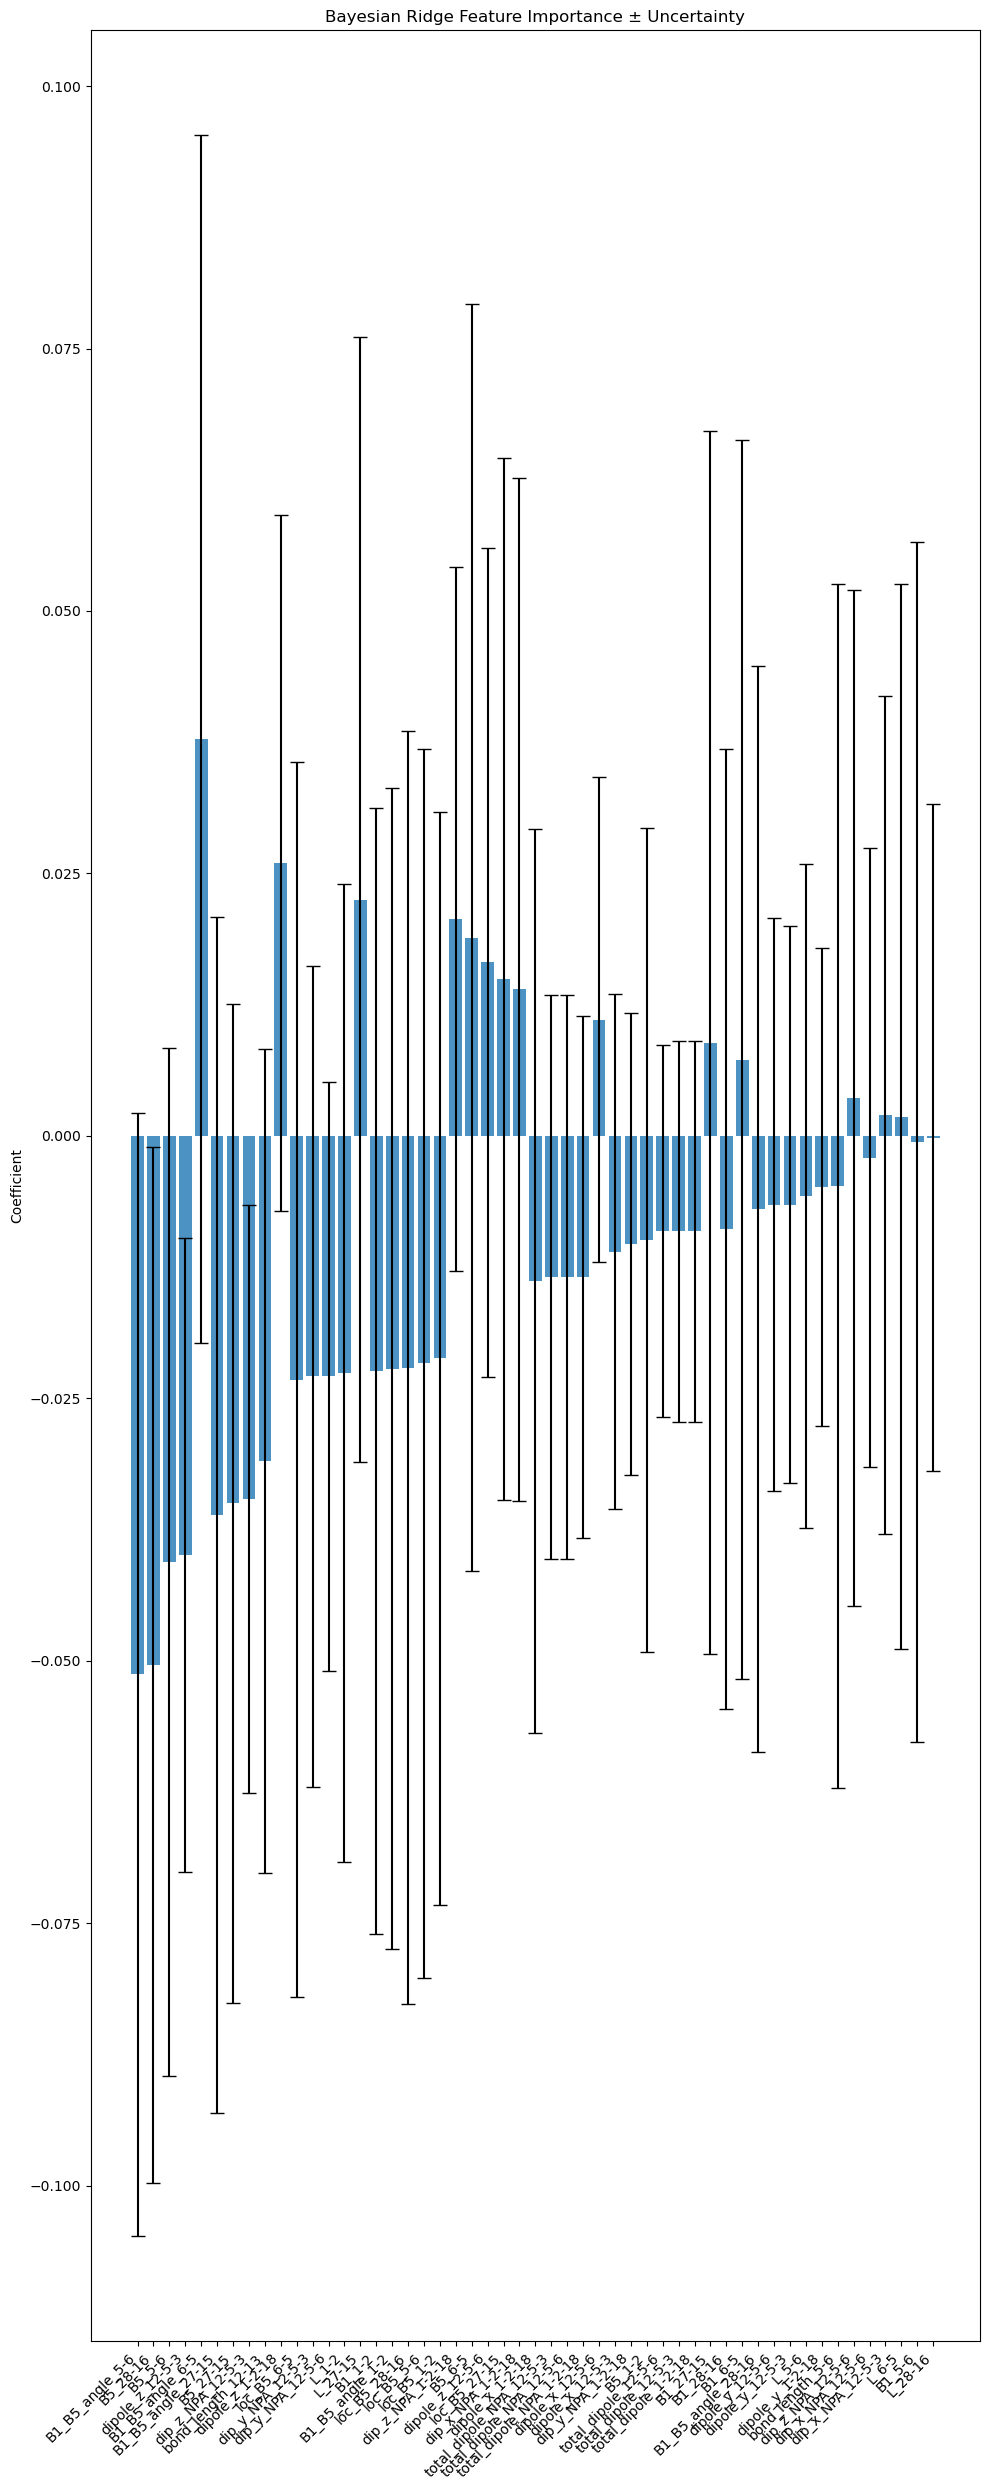

In [7]:
runner.analyze_bayesian_ridge(plot=True)

In [4]:
y_true, y_pred, metrics ,x= runner.leave_out_predict('Bayes. Ridge', [5, 20, 2])

Leave-out indices: ['LS1643', 'LS1723', 'LS1630']
MSE: 0.1961  MAE: 0.4146  RMSE: 0.4428

 Index  True  Pred  Percent_Error
     2 0.000 0.477            NaN
     5 2.304 2.104         -8.710
    20 0.058 0.624        975.408


In [5]:
for i in range(5):
    i+=1
    runner.linear_with_top_bayesridge_features_cv(n_top=i)


Top 1 features from Bayesian Ridge: ['hirshfeld_atom_12']


c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 scor

Cross-validated performance:
CV3: MSE=0.2593, MAE=0.4603, RMSE=0.5092, R2=0.4159
CV5: MSE=0.2567, MAE=0.4585, RMSE=0.5067, R2=-0.7534
LOO: MSE=0.2433, MAE=0.4505, RMSE=0.4933, R2=nan
Top 2 features from Bayesian Ridge: ['hirshfeld_atom_12', 'HOMO-LUMO Gap (eV)']


c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 scor

Cross-validated performance:
CV3: MSE=0.2053, MAE=0.4090, RMSE=0.4531, R2=0.5461
CV5: MSE=0.2088, MAE=0.4148, RMSE=0.4569, R2=-0.6114
LOO: MSE=0.2134, MAE=0.4260, RMSE=0.4620, R2=nan
Top 3 features from Bayesian Ridge: ['hirshfeld_atom_12', 'HOMO-LUMO Gap (eV)', 'dipole_z_10-11-12']


c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 scor

Cross-validated performance:
CV3: MSE=0.1678, MAE=0.3263, RMSE=0.4096, R2=0.6396
CV5: MSE=0.1480, MAE=0.3162, RMSE=0.3847, R2=-0.0521
LOO: MSE=0.1528, MAE=0.3224, RMSE=0.3909, R2=nan
Top 4 features from Bayesian Ridge: ['hirshfeld_atom_12', 'HOMO-LUMO Gap (eV)', 'dipole_z_10-11-12', 'B5_19-18']
Cross-validated performance:
CV3: MSE=0.1815, MAE=0.3438, RMSE=0.4260, R2=0.5957
CV5: MSE=0.1508, MAE=0.3095, RMSE=0.3883, R2=-0.1405
LOO: MSE=0.1551, MAE=0.3143, RMSE=0.3938, R2=nan


c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 scor

Top 5 features from Bayesian Ridge: ['hirshfeld_atom_12', 'HOMO-LUMO Gap (eV)', 'dipole_z_10-11-12', 'B5_19-18', 'cross_angle']
Cross-validated performance:
CV3: MSE=0.1906, MAE=0.3523, RMSE=0.4366, R2=0.5719
CV5: MSE=0.1645, MAE=0.3389, RMSE=0.4055, R2=-0.1198
LOO: MSE=0.1670, MAE=0.3394, RMSE=0.4086, R2=nan


c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
c:\Users\edens\anaconda3\envs\labenv\lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 scor

In [11]:

runner.run_spike_and_slab_selection()
selected_features = runner.get_selected_features_spike_and_slab(threshold=0.6)
print("Selected features:", selected_features)            

Multiprocess sampling (2 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [spike]
>NUTS: [betas_slab, intercept, sigma]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 1296 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Spike-and-Slab Feature Inclusion Probabilities:
nbo_atom_1            P(included) = 0.078
nbo_atom_2            P(included) = 0.244
nbo_atom_3            P(included) = 0.133
nbo_atom_5            P(included) = 0.127
nbo_atom_12           P(included) = 0.114
nbo_atom_6            P(included) = 0.142
hirshfeld_atom_1      P(included) = 0.186
hirshfeld_atom_2      P(included) = 0.301
hirshfeld_atom_3      P(included) = 0.121
hirshfeld_atom_5      P(included) = 0.142
hirshfeld_atom_12     P(included) = 0.065
hirshfeld_atom_6      P(included) = 0.156
cm5_atom_1            P(included) = 0.170
cm5_atom_2            P(included) = 0.207
cm5_atom_3            P(included) = 0.103
cm5_atom_5            P(included) = 0.085
cm5_atom_12           P(included) = 0.113
cm5_atom_6            P(included) = 0.138
Frequency_Stretch_1_2  P(included) = 0.087
loc_B5_27-15          P(included) = 0.043
dip_z_NPA_12-5-6      P(included) = 0.031
Selected features: []


In [ ]:
['loc_B5_27-15','bond_length_12-13','dip_z_NPA_12-5-6']